In [16]:
# =========================================
# Colab-ready pipeline for:
# Angry CNN comments -> anger target (8 classes) -> ICE stance
# Input: CNN_Comments_Final.csv
# =========================================

import os
import re
import json
import zipfile
import urllib.request
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [17]:
import re
import numpy as np

# NLTK resources (Colab / new nltk)
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
INPUT_CSV = "/content/drive/MyDrive/CNN_DTM_Analysis_Results.csv"

In [20]:
!pip -q install regex
import regex as re2

In [21]:
def extract_emojis(s):
    return re2.findall(r"\p{Emoji_Presentation}|\p{Extended_Pictographic}", str(s))

def clean_text(s: str) -> str:
    s = str(s).lower()
    # per your requirement: lowercase + remove punctuation/special chars
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def penn_to_wn(tag: str):
    # keep only noun/verb/adj (per your requirement)
    if tag.startswith("NN"):
        return NOUN
    if tag.startswith("VB"):
        return VERB
    if tag.startswith("JJ"):
        return ADJ
    return None

# Stopwords: remove get/got to avoid killing imperative phrases like "get out"
BASE_STOP = set(stopwords.words("english"))
EXTRA_STOP = {
    "will","would","this","that","these","those","there","here","also","just",
    "like","one","u","ur","im","youre","hes","shes","theyre","weve",
    "amp","lol","lmao","omg","dont","doesnt","didnt","cant","wont","isnt","arent",
    "ive","id","youve","youd","theyve","theyd","whats","thats","theres","heres",
    "rt","via"
}
STOP = BASE_STOP.union(EXTRA_STOP)

LEMM = WordNetLemmatizer()

# Strong keep list: never dropped even if POS/stopword would remove it
SLANG_KEEP = {"fafo", "acab", "fjb", "maga", "dhs", "ice"}

# Phrase merge: preserve stance-carrying imperative phrases
PHRASES = {
    ("get", "out"),
    ("go", "back"),
    ("send", "back"),
    ("ice", "out"),
    ("kick", "out"),
    ("lock", "up"),
}

def merge_phrases(tokens):
    i, merged = 0, []
    while i < len(tokens):
        if i + 1 < len(tokens) and (tokens[i], tokens[i+1]) in PHRASES:
            merged.append(tokens[i] + "_" + tokens[i+1])
            i += 2
        else:
            merged.append(tokens[i])
            i += 1
    return merged

def preprocess_comment(text: str):
    """
    EXACT required order:
    clean -> NLTK tokenize -> POS filter (N/V/Adj) -> lemmatize -> extended stopwords
    Output: list of effective tokens
    """
    t = clean_text(text)
    tokens = word_tokenize(t)
    tokens = merge_phrases(tokens)  # still in tokenization stage
    tagged = pos_tag(tokens)

    out = []
    for w, tag in tagged:
        w = w.lower()

        # strong keep first (prevents information loss like "fafo")
        if w in SLANG_KEEP:
            out.append(w)
            continue

        wn_pos = penn_to_wn(tag)
        if wn_pos is None:
            continue

        if w in STOP:
            continue

        lemma = LEMM.lemmatize(w, pos=wn_pos)
        if lemma and lemma not in STOP and len(lemma) > 1:
            out.append(lemma)

    return out

def cosine(a: np.ndarray, b: np.ndarray) -> float:
    if a is None or b is None:
        return -1.0
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return -1.0
    return float(np.dot(a, b) / (na * nb))

def contains_phrase(text_clean: str, phrase: str) -> bool:
    return re.search(rf"\b{re.escape(phrase)}\b", text_clean) is not None

In [22]:

# Step 1: Load data + filter angry comments


if not os.path.exists(INPUT_CSV):
    # allow running when file is in current working dir
    INPUT_CSV = "CNN_DTM_Analysis_Results.csv"
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError("Cannot find CNN_DTM_Analysis_Results.csv. Upload it to Colab (Files) root or /content/.")

df = pd.read_csv(INPUT_CSV)

# Auto-detect columns
# emotion column candidates
emotion_candidates = [c for c in df.columns if c.lower() in ["emotion", "sentiment", "label"]]
# text column candidates
text_candidates = [c for c in df.columns if c.lower() in ["comment_text","comment","text","body","content","message"]]

if not emotion_candidates:
    raise ValueError(f"Cannot find emotion column. Existing columns: {list(df.columns)}")
if not text_candidates:
    raise ValueError(f"Cannot find text column. Existing columns: {list(df.columns)}")

emotion_col = emotion_candidates[0]
text_col = text_candidates[0]

anger_df = df[df[emotion_col].astype(str).str.lower() == "anger"].copy()
anger_df.reset_index(drop=True, inplace=True)

print(f"[Step1] emotion_col={emotion_col}, text_col={text_col}")
print(f"[Step1] Total angry comments: {len(anger_df)}")

# Preprocess all angry comments (no skipping)
tokens_list = []
vocab = set()

for txt in anger_df[text_col].astype(str).tolist():
    toks = preprocess_comment(txt)
    tokens_list.append(toks)
    vocab.update(toks)

anger_df["tokens"] = tokens_list
print(f"[Step1] Vocab size after preprocessing: {len(vocab)}")



[Step1] emotion_col=emotion, text_col=comment_text
[Step1] Total angry comments: 39220
[Step1] Vocab size after preprocessing: 21021


In [23]:
anger_df["tokens"] = anger_df["comment_text"].astype(str).apply(preprocess_comment)


In [24]:
fafo_cnt = sum("fafo" in set(t) for t in anger_df["tokens"])
print("comments containing fafo:", fafo_cnt)

for p in ["get_out","go_back","send_back","ice_out"]:
    c = sum(p in set(t) for t in anger_df["tokens"])
    print(p, "comments:", c)

anger_df["emoji_seq"] = anger_df["comment_text"].apply(extract_emojis)
print("comments with emoji:", (anger_df["emoji_seq"].apply(len) > 0).mean())

comments containing fafo: 317
get_out comments: 690
go_back comments: 111
send_back comments: 2
ice_out comments: 36
comments with emoji: 0.09898011218765936


In [25]:
# Step 2
import os, zipfile, urllib.request

GLOVE_ZIP_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "/content/glove.6B.zip"
GLOVE_TXT = "/content/glove.6B.300d.txt"

def is_valid_zip(path):
    if not os.path.exists(path):
        return False
    try:
        with zipfile.ZipFile(path, "r") as z:
            bad = z.testzip()
            return bad is None
    except Exception:
        return False

def download_glove():
    # already extracted
    if os.path.exists(GLOVE_TXT):
        print("[Step2] GloVe txt already exists:", GLOVE_TXT)
        return

    # zip exists but broken -> delete
    if os.path.exists(GLOVE_ZIP) and (not is_valid_zip(GLOVE_ZIP)):
        print("[Step2] Found corrupted zip, deleting:", GLOVE_ZIP)
        os.remove(GLOVE_ZIP)

    # download zip if needed
    if not os.path.exists(GLOVE_ZIP):
        print("[Step2] Downloading GloVe zip...")
        urllib.request.urlretrieve(GLOVE_ZIP_URL, GLOVE_ZIP)

    # validate again
    if not is_valid_zip(GLOVE_ZIP):
        # if still invalid, delete and hard-fail
        os.remove(GLOVE_ZIP)
        raise RuntimeError("[Step2] Downloaded file is still not a valid zip. Re-run this cell to retry.")

    # extract 300d
    print("[Step2] Extracting glove.6B.300d.txt ...")
    with zipfile.ZipFile(GLOVE_ZIP, "r") as z:
        z.extract("glove.6B.300d.txt", path="/content")

download_glove()


[Step2] Downloading GloVe zip...
[Step2] Extracting glove.6B.300d.txt ...


In [26]:
KW_LOCAL = set("""
mayor governor city state council cityhall
walz frey minneapolis minnesota mn
""".split())

In [33]:
def comment_embedding(tokens):
    vecs = [glove[w] for w in tokens if w in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(300)

In [37]:
import numpy as np

def load_glove_300d(glove_txt_path: str, dim: int = 300):
    glove = {}
    with open(glove_txt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            if vec.shape[0] != dim:
                continue
            glove[word] = vec
    return glove

glove = load_glove_300d(GLOVE_TXT, dim=300)

def comment_embedding(tokens, dim=300):
    vecs = [glove[w] for w in tokens if w in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim, dtype=np.float32)

print("[Step2] glove loaded:", len(glove))


[Step2] glove loaded: 400000


In [40]:
import numpy as np

def mean_vec(words, dim=300):
    vecs = [glove[w] for w in words if w in glove]
    return np.mean(vecs, axis=0).astype(np.float32) if vecs else np.zeros(dim, dtype=np.float32)

# A) ICE centroid for semantic gating / similarity
ICE_SEED = ["ice","dhs","ero","deport","deportation","immigration","border","enforcement","raid"]
ice_centroid = mean_vec(ICE_SEED)

# B) Prototypes used inside classify_anger_object (soft evidence)
proto_ice = mean_vec(["ice","dhs","deportation","immigration","border"])
proto_trump = mean_vec(["trump","donald","president","maga"])
proto_localgov = mean_vec(["mayor","governor","city","state","minneapolis"])
proto_immig = mean_vec(["immigrant","immigration","migrant","asylum","refugee","undocumented","illegal"])
proto_indirect = mean_vec(["corrupt","corruption","justice","court","system","government","law","rights","unconstitutional"])

print("[Step2.5] ice_centroid/prototypes ready.",
      "ice_centroid_norm=", float(np.linalg.norm(ice_centroid)))


[Step2.5] ice_centroid/prototypes ready. ice_centroid_norm= 3.495305299758911


In [44]:
# ---- Keyword sets required by classify_anger_object ----

KW_VICTIM = set("""
victim killed shot shooter murder murdered murdered
""".split())

KW_LOCAL = set("""
mayor governor city state council official officials frey walz minneapolis
""".split())

KW_ICE = set("""
ice dhs ero deport deportation immigration immigrant immigrants border enforcement raid
""".split())

KW_RESIST = set("""
sanctuary resist resisting refusal refuse defy defying block blocked obstruct
""".split())

KW_SUPPORT = set("""
support cooperate cooperating assist helping aid back backed endorse
""".split())

KW_TRUMP = set("""
trump donald maga president
""".split())

KW_INDIRECT = set("""
corrupt corruption justice court system government law laws unconstitutional tyranny rights abuse
""".split())

KW_IMMIG = set("""
immigration immigrant immigrants migrant migrants asylum refugee refugees undocumented illegal illegals alien aliens
""".split())


In [28]:
# Robust GloVe download (self-healing)
def is_valid_zip(path):
    if not os.path.exists(path):
        return False
    try:
        with zipfile.ZipFile(path, "r") as z:
            return z.testzip() is None
    except Exception:
        return False

def download_glove():
    if os.path.exists(GLOVE_TXT):
        return

    # Delete corrupted zip
    if os.path.exists(GLOVE_ZIP) and (not is_valid_zip(GLOVE_ZIP)):
        print("[Step2] Found corrupted zip, deleting:", GLOVE_ZIP)
        os.remove(GLOVE_ZIP)

    if not os.path.exists(GLOVE_ZIP):
        print("[Step2] Downloading GloVe (glove.6B.zip)...")
        urllib.request.urlretrieve(GLOVE_ZIP_URL, GLOVE_ZIP)

    if not is_valid_zip(GLOVE_ZIP):
        # Force retry next run
        os.remove(GLOVE_ZIP)
        raise RuntimeError("[Step2] Downloaded glove.6B.zip is not a valid zip. Re-run this cell to retry.")

    print("[Step2] Extracting glove.6B.300d.txt ...")
    with zipfile.ZipFile(GLOVE_ZIP, "r") as z:
        z.extract("glove.6B.300d.txt", path="/content")

download_glove()

def classify_anger_object(raw_text: str, tokens: list, emb: np.ndarray, sim_ice: float):
    tclean = clean_text(raw_text)
    tokset = set(tokens)

    renee_good = contains_phrase(tclean, "renee good")
    renee = "renee" in tokset or contains_phrase(tclean, "renee")
    good = "good" in tokset
    victim_context = (len(tokset & KW_VICTIM) > 0)

    has_local = (len(tokset & KW_LOCAL) > 0)
    has_ice_terms = (len(tokset & KW_ICE) > 0) or contains_phrase(tclean, "ice")

    resist_cue = len(tokset & KW_RESIST) > 0 or any(contains_phrase(tclean, p) for p in ["sanctuary city", "sanctuary state"])
    support_cue = len(tokset & KW_SUPPORT) > 0

    has_trump = (len(tokset & KW_TRUMP) > 0) or contains_phrase(tclean, "trump administration")
    has_indirect = len(tokset & KW_INDIRECT) > 0
    has_immig = len(tokset & KW_IMMIG) > 0 or any(contains_phrase(tclean, p) for p in ["illegal immigrant", "illegal immigrants", "illegal alien", "illegal aliens"])

    # Soft evidence
    s_ice = cosine(emb, proto_ice)
    s_trump = cosine(emb, proto_trump)
    s_local = cosine(emb, proto_localgov)
    s_immig = cosine(emb, proto_immig)
    s_ind = cosine(emb, proto_indirect)

    # ⑤ Renee Good victim
    if renee_good or (renee and victim_context) or (renee and good and victim_context):
        return "⑤Victim (Renee Good)"
    # ⑤ Renee Good victim (duplicate; can be removed)
    if renee_good or (renee and victim_context) or (renee and good and victim_context):
        return "⑤Victim (Renee Good)"

    # === NEW RULE (your decision): any mayor/governor mention => ③ ===
    if has_local:
        return "③Local government"

    # ① ICE agency
    if has_ice_terms or (s_ice >= 0.45 and sim_ice >= 0.4):
        if has_local and (resist_cue or support_cue) and (has_ice_terms or sim_ice >= 0.4):
            pass
        else:
            return "①ICE agency"

    # ② Trump administration
    if has_trump or (s_trump >= 0.45):
        return "②Trump"

    # ⑥ Illegal immigrants
    if has_immig and not has_trump and (not has_ice_terms):
        return "⑥Undocumented immigrants"

    # ⑦ Corruption/system (must not be treated as irrelevant)
    if has_indirect and (sim_ice >= 0.4 or s_ind >= 0.45):
        return "⑦Corruption / justice-system / government failures"
    if (s_ind >= 0.50 and sim_ice >= 0.4):
        return "⑦Corruption / justice-system / government failures"

    # ... Keep your original ⑧ + fallback logic below unchanged ...

    # -----------------------------
    # ⑧ + fallback (ADJUSTED) — must be inside the function
    # -----------------------------
    tok_len = len(tokens)

    # Stricter: only treat as pure venting when relevance is extremely low,
    # the text is very short, and there are no target cues
    if sim_ice < 0.25 and tok_len <= 2 and not (has_trump or has_local or has_ice_terms or has_immig or has_indirect):
        return "⑧Pure emotional venting"

    # Relaxed recovery: if prototype similarity is high enough, recover a target
    # (no longer requiring sim_ice >= 0.4)
    candidates = {
        "①ICE agency": s_ice,
        "②Trump": s_trump,
        "⑥Undocumented immigrants": s_immig,
        "⑦Corruption / justice-system / government failures": s_ind
    }
    best_obj, best_score = max(candidates.items(), key=lambda x: x[1] if x[1] is not None else -1.0)

    if best_score is not None and best_score >= 0.40:
        return best_obj

    return "⑧Pure emotional venting"



In [29]:
# Step 3: Map anger object -> ICE stance

STANCE_MAP = {
    "①ICE agency": "Oppose ICE (direct)",
    "②Trump": "Oppose ICE (direct)",
    "③Local government": "Support ICE",
    "④Local government": "Oppose ICE (direct)",
    "⑤Victim (Renee Good)": "Oppose ICE (direct)",
    "⑥Undocumented immigrants": "Support ICE",
    "⑦Corruption / justice-system / government failures": "Oppose ICE (indirect)",
    "⑧Pure emotional venting": "Irrelevant to ICE",
}

def map_to_stance(obj: str) -> str:
    obj = str(obj).strip()
    if obj in STANCE_MAP:
        return STANCE_MAP[obj]

    # Fault tolerance: if someone writes ① as (1) or "1." etc., infer by the leading symbol/number
    if obj.startswith(("1", "①", "(1)")):
        return "Oppose ICE (direct)"
    if obj.startswith(("2", "②", "(2)")):
        return "Oppose ICE (direct)"
    if obj.startswith(("3", "③", "(3)")):
        return "Support ICE"
    if obj.startswith(("4", "④", "(4)")):
        return "Oppose ICE (direct)"
    if obj.startswith(("5", "⑤", "(5)")):
        return "Oppose ICE (direct)"
    if obj.startswith(("6", "⑥", "(6)")):
        return "Support ICE"
    if obj.startswith(("7", "⑦", "(7)")):
        return "Oppose ICE (indirect)"
    return "Irrelevant to ICE"



In [45]:
# Run STRICT classification (minimal)

objects, stances = [], []

for raw, toks in zip(anger_df[text_col].astype(str).tolist(), anger_df["tokens"].tolist()):
    emb = comment_embedding(toks)
    sim_ice = cosine(emb, ice_centroid)  # only needed if classify_anger_object uses it
    obj = classify_anger_object(raw, toks, emb, sim_ice)
    stance = map_to_stance(obj)

    objects.append(obj)
    stances.append(stance)

anger_df["anger_object"] = objects
anger_df["ice_stance"] = stances


In [46]:
# =========================================
# Step 3.5: INFERRED Rebuild (replace all code after Step 3 mapping)
# Core idea:
# 1) First gate: is it ICE-related? If not, keep class ⑧ (stance = Irrelevant to ICE)
# 2) If ICE-related and current obj == ⑧, infer among ①–⑦ with posterior = prior * likelihood
# 3) Add a confidence threshold: if max posterior < TAU, keep ⑧
# 4) Likelihood uses BOTH embedding similarity and rule cues (resist/support/immig/ICE terms)
# =========================================

import numpy as np
import pandas as pd
import re

OBJ_ALL = [
    "①ICE agency",
    "②Trump",
    "③Local government (resisting ICE)",
    "④Local government (supporting ICE)",
    "⑤Victim (Renee Good)",
    "⑥Undocumented immigrants",
    "⑦Corruption / justice-system / government failures",
    "⑧Pure emotional venting",
]
OBJ_MAIN = OBJ_ALL[:-1]  # ①–⑦

def safe_cos(a, b):
    v = cosine(a, b)
    return -1.0 if v is None else float(v)

def softmax(x):
    x = np.asarray(x, dtype=np.float32)
    x = x - np.max(x)
    ex = np.exp(x)
    s = ex.sum()
    return ex / s if s > 0 else np.ones_like(ex) / len(ex)

ICE_TRIGGERS = ["ice", "deport", "deportation", "immigration", "border", "enforcement", "raid", "ero", "dhs"]

def has_trigger(raw_text: str) -> bool:
    t = clean_text(raw_text)
    # If any trigger term appears, treat as potentially ICE-related
    return any(re.search(rf"\b{re.escape(k)}\b", t) for k in ICE_TRIGGERS)

def cue_flags(raw_text: str, tokens: list):
    tclean = clean_text(raw_text)
    tokset = set(tokens)

    resist_cue = (len(tokset & KW_RESIST) > 0) or any(
        contains_phrase(tclean, p) for p in ["sanctuary city", "sanctuary state"]
    )
    support_cue = (len(tokset & KW_SUPPORT) > 0)

    has_immig = (len(tokset & KW_IMMIG) > 0) or any(
        contains_phrase(tclean, p) for p in ["illegal immigrant", "illegal immigrants", "illegal alien", "illegal aliens"]
    )
    has_ice = (len(tokset & KW_ICE) > 0) or contains_phrase(tclean, "ice")
    has_trump = (len(tokset & KW_TRUMP) > 0) or contains_phrase(tclean, "trump administration")
    has_ind = (len(tokset & KW_INDIRECT) > 0)

    return resist_cue, support_cue, has_immig, has_ice, has_trump, has_ind

def is_ice_related(raw_text: str, tokens: list, emb: np.ndarray):
    # Gate logic: trigger OR semantic similarity
    sim_ice = safe_cos(emb, ice_centroid)
    trig = has_trigger(raw_text)
    return (trig or sim_ice >= 0.30), sim_ice

LOCAL_PROTO = proto_localgov2 if "proto_localgov2" in globals() else proto_localgov

def likelihood_over_objs(raw_text: str, tokens: list):
    emb = comment_embedding(tokens)
    if emb is None:
        emb = np.zeros(300, dtype=np.float32)

    resist_cue, support_cue, has_immig, has_ice, has_trump, has_ind = cue_flags(raw_text, tokens)

    s_ice = safe_cos(emb, proto_ice)
    s_trump = safe_cos(emb, proto_trump)
    s_loc = safe_cos(emb, LOCAL_PROTO)
    s_imm = safe_cos(emb, proto_immig)
    s_ind = safe_cos(emb, proto_indirect)

    SCALE = 6.0  # empirical scaling to sharpen the distribution

    # Cue bonuses: ensure stable entry points for ③/④ and ⑥ (avoid being flattened by priors)
    bonus_3 = 0.60 if resist_cue else 0.0
    bonus_4 = 0.60 if support_cue else 0.0
    bonus_6 = 0.50 if has_immig else 0.0
    bonus_1 = 0.40 if has_ice else 0.0
    bonus_2 = 0.40 if has_trump else 0.0
    bonus_7 = 0.35 if has_ind else 0.0

    # For ⑤ (Victim), rely on strict detection (e.g., Renee); no advantage in inferred recovery
    score = {
        "①ICE agency": s_ice + bonus_1,
        "②Trump": s_trump + bonus_2,
        "③Local government (resisting ICE)": s_loc + bonus_3,
        "④Local government (supporting ICE)": s_loc + bonus_4,
        "⑤Victim (Renee Good)": -0.20,
        "⑥Undocumented immigrants": s_imm + bonus_6,
        "⑦Corruption / justice-system / government failures": s_ind + bonus_7,
    }

    vec = [score[o] * SCALE for o in OBJ_MAIN]
    return softmax(vec)  # len = 7

ALPHA = 0.5  # smoothing

def build_global_prior(df):
    vc = df.loc[df["anger_object"] != "⑧Pure emotional venting", "anger_object"].value_counts()
    arr = vc.reindex(OBJ_MAIN).fillna(0).values.astype(np.float32)
    arr = (arr + ALPHA) / (arr.sum() + ALPHA * len(OBJ_MAIN))
    return arr

prior_global = build_global_prior(anger_df)

video_prior = None
if "video_id" in anger_df.columns:
    tmp = anger_df.loc[anger_df["anger_object"] != "⑧Pure emotional venting", ["video_id", "anger_object"]].copy()
    counts = (
        tmp.groupby(["video_id", "anger_object"])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=OBJ_MAIN, fill_value=0)
    )
    video_prior = (counts + ALPHA).div((counts.sum(axis=1) + ALPHA * len(OBJ_MAIN)), axis=0)

TAU = 0.45
MIN_SIM_ICE = 0.30
USE_GATE = True

def infer_obj_v2(row):
    raw = row[text_col]
    toks = row["tokens"]

    # 1) Non-⑧: keep strict label; do not allow the gate to override
    if row["anger_object"] != "⑧Pure emotional venting":
        emb = comment_embedding(toks)
        sim_ice = safe_cos(emb, ice_centroid) if emb is not None else -1.0
        return row["anger_object"], 1.0, sim_ice, "keep_strict"

    # 2) Only for strict = ⑧: apply gating + recovery
    emb = comment_embedding(toks)
    if emb is None:
        emb = np.zeros(300, dtype=np.float32)

    related, sim_ice = is_ice_related(raw, toks, emb)

    if USE_GATE and (not related):
        return "⑧Pure emotional venting", 1.0, sim_ice, "gate_not_related"

    like = likelihood_over_objs(raw, toks)

    if (video_prior is not None) and (row.get("video_id", None) in video_prior.index):
        prior = video_prior.loc[row["video_id"]].values.astype(np.float32)
    else:
        prior = prior_global

    post = prior * like
    s = post.sum()
    post = post / s if s > 0 else np.ones(len(OBJ_MAIN)) / len(OBJ_MAIN)

    k = int(np.argmax(post))
    best_obj = OBJ_MAIN[k]
    best_p = float(post[k])

    if best_p < TAU:
        return "⑧Pure emotional venting", best_p, sim_ice, "low_conf_keep_8"

    return best_obj, best_p, sim_ice, "inferred"

res = anger_df.apply(infer_obj_v2, axis=1, result_type="expand")
anger_df["anger_object_inferred"] = res[0]
anger_df["inference_confidence"] = res[1]
anger_df["ice_semantic_sim_infer"] = res[2]
anger_df["infer_reason"] = res[3]

# Stance mapping: reuse your STANCE_MAP to keep consistent
anger_df["ice_stance_inferred"] = anger_df["anger_object_inferred"].apply(map_to_stance)

print("Original class-⑧ count:", (anger_df["anger_object"] == "⑧Pure emotional venting").sum())
print("Inferred class-⑧ count:", (anger_df["anger_object_inferred"] == "⑧Pure emotional venting").sum())
print(
    "Mean confidence on original-⑧:",
    anger_df.loc[anger_df["anger_object"] == "⑧Pure emotional venting", "inference_confidence"].mean()
)

print("\nInference reason breakdown (only original-⑧):")
print(anger_df.loc[anger_df["anger_object"] == "⑧Pure emotional venting", "infer_reason"].value_counts())

print("\nSupport-pool source (inferred):")
print(pd.crosstab(
    anger_df["anger_object"], anger_df["ice_stance_inferred"],
    rownames=["strict_obj"], colnames=["inferred_stance"]
))



Original class-⑧ count: 7614
Inferred class-⑧ count: 7284
Mean confidence on original-⑧: 0.9843671752581735

Inference reason breakdown (only original-⑧):
infer_reason
gate_not_related    7279
inferred             330
low_conf_keep_8        5
Name: count, dtype: int64

Support-pool source (inferred):
inferred_stance                                     Irrelevant to ICE  \
strict_obj                                                              
①ICE agency                                                         0   
②Trump                                                              0   
③Local government                                                   0   
⑤Victim (Renee Good)                                                0   
⑥Undocumented immigrants                                            0   
⑦Corruption / justice-system / government failures                  0   
⑧Pure emotional venting                                          7284   

inferred_stance                         

In [48]:
#Step3.6: Refine stance for ⑦ only (HIGH-PRECISION)


# ① Immigration-topic signals: if any appear, the class-⑦ comment is likely discussing immigration/border issues
KW_IMMIG_TOPIC = set("""
immigration immigrant immigrants migrant migrants asylum refugee refugees
border borders
illegal illegals undocumented papers paperwork
visa visas
""".split())

PH_IMMIG_TOPIC = [
    "without papers", "no papers", "undocumented", "illegal immigrants", "illegal aliens",
    "crossing the border", "at the border"
]

# ② Pro–strict-enforcement / deportation signals:
# only when these appear can a comment be interpreted as “supporting enforcement / supporting ICE”
KW_ENFORCE = set("""
deport deported deporting deportation
remove removed removal
expel expelled expelling
sendback
""".split())

PH_ENFORCE = [
    "send them back", "send 'em back", "send em back",
    "deport them", "deport 'em", "deport em",
    "come here legally", "come here legal", "enter legally"
]

# ③ Anti-ICE / anti–abuse-of-power signals:
# used as a conservative brake—if triggered, prioritize opposition
KW_ANTI_ICE = set("""
abolish icegestapo gestapo
police state policestate
fascist fascism nazi
brutality brutal unconstitutional tyranny
""".split())

PH_ANTI_ICE = ["abolish ice", "ice gestapo", "police state", "state violence"]

def s7_secondary_stance(raw_text: str, tokens: list):
    t = clean_text(raw_text)
    tokset = set(tokens)

    anti_ice = (len(tokset & KW_ANTI_ICE) > 0) or any(contains_phrase(t, p) for p in PH_ANTI_ICE)

    topic = (len(tokset & KW_IMMIG_TOPIC) > 0) or any(contains_phrase(t, p) for p in PH_IMMIG_TOPIC)
    enforce = (len(tokset & KW_ENFORCE) > 0) or any(contains_phrase(t, p) for p in PH_ENFORCE)

    # Key constraint: remove/removal terms are only allowed to contribute to “support”
    # when topic == True (otherwise most cases are political, e.g., “remove her from office”)
    pro_enforce = topic and enforce

    # In case of conflict: be conservative and prioritize anti-ICE
    if anti_ice and (not pro_enforce):
        return "Oppose ICE (indirect)", "s7_anti_ice"
    if pro_enforce and (not anti_ice):
        return "Support ICE", "s7_pro_enforce(topic+enforce)"
    if anti_ice and pro_enforce:
        return "Oppose ICE (indirect)", "s7_conflict->anti"
    return "Oppose ICE (indirect)", "s7_default_indirect"

# Apply refinement
anger_df["ice_stance_refined"] = anger_df["ice_stance_inferred"]
anger_df["stance_reason_refined"] = "base_map"

mask_s7 = anger_df["anger_object_inferred"].eq("⑦Corruption / justice-system / government failures")
tmp = anger_df.loc[mask_s7].apply(
    lambda r: s7_secondary_stance(r[text_col], r["tokens"]),
    axis=1, result_type="expand"
)
anger_df.loc[mask_s7, "ice_stance_refined"] = tmp[0]
anger_df.loc[mask_s7, "stance_reason_refined"] = tmp[1]




In [49]:
mask_s7 = anger_df["anger_object_inferred"].eq("⑦Corruption / justice-system / government failures")
moved = (
    mask_s7
    & (anger_df["ice_stance_inferred"] == "Oppose ICE (indirect)")
    & (anger_df["ice_stance_refined"] == "Support ICE")
)

print("moved_to_support:", moved.sum())
print(
    anger_df.loc[moved, [text_col, "stance_reason_refined"]]
    .sample(min(30, moved.sum()), random_state=7)
    .to_string(index=False)
)

print("\nREFINED stance counts:")
print(anger_df["ice_stance_refined"].value_counts())

moved_to_support: 3
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  comment_text         stance_reason_refined
                                                                                       


[STRICT Result ①] Anger-object counts / percentages:
                                                    count  pct(%)
anger_object                                                     
⑦Corruption / justice-system / government failures  14382   36.67
①ICE agency                                          9831   25.07
⑧Pure emotional venting                              7614   19.41
②Trump                                               3454    8.81
③Local government                                    2758    7.03
⑥Undocumented immigrants                              838    2.14
⑤Victim (Renee Good)                                  343    0.87

[STRICT Result ②] ICE-stance counts / percentages:
                       count  pct(%)
ice_stance                          
Oppose ICE (indirect)  14382   36.67
Oppose ICE (direct)    13628   34.75
Irrelevant to ICE       7614   19.41
Support ICE             3596    9.17

[STRICT Result ③] Core stance ratio (Support vs. Oppose; direct+indirect oppo

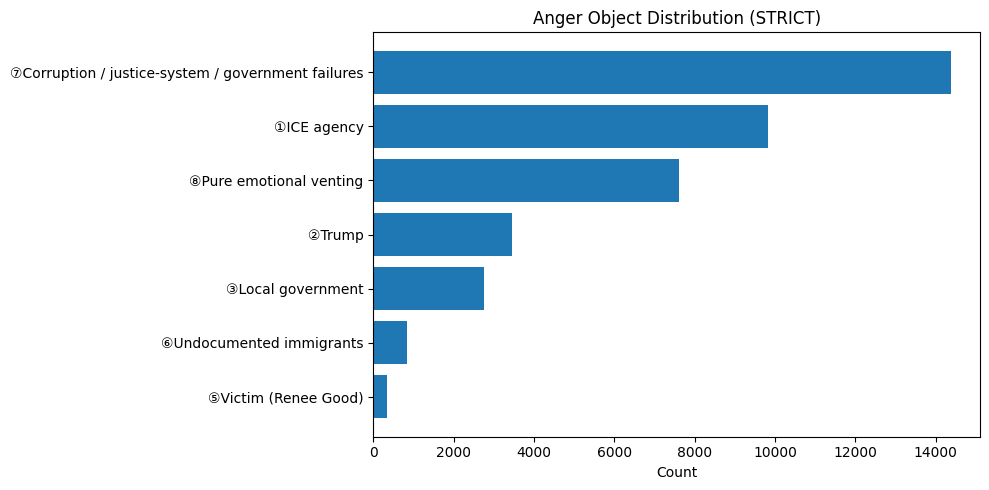

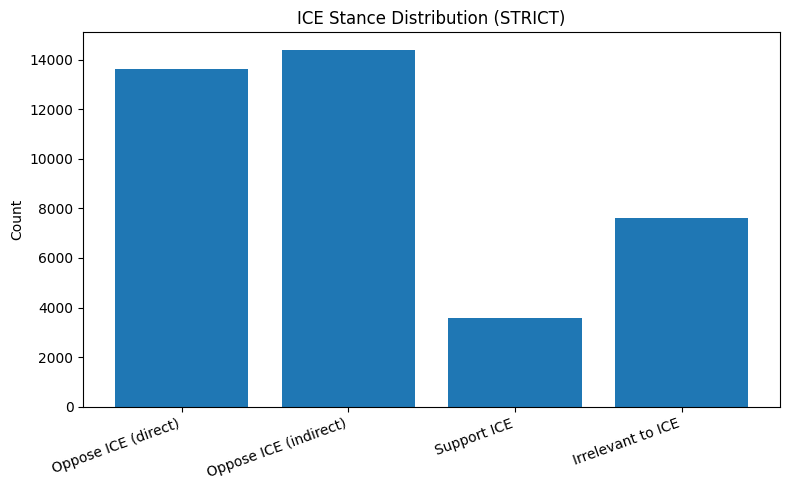

In [52]:
# Step 4 (STRICT ONLY): Stats + Visualization (no saving)

import pandas as pd
import matplotlib.pyplot as plt

def count_and_pct(series: pd.Series):
    cnt = series.value_counts()
    pct = (cnt / cnt.sum() * 100).round(2)
    return pd.DataFrame({"count": cnt, "pct(%)": pct})

def print_block(title, df_stats):
    print(f"\n{title}")
    print(df_stats)

def core_support_oppose(stance_series: pd.Series):
    core = stance_series[stance_series != "Irrelevant to ICE"]
    support_n = (core == "Support ICE").sum()
    oppose_n = core.isin(["Oppose ICE (direct)", "Oppose ICE (indirect)"]).sum()
    total_core = int(support_n + oppose_n)
    support_pct = round(support_n / total_core * 100, 2) if total_core else 0.0
    oppose_pct = round(oppose_n / total_core * 100, 2) if total_core else 0.0
    return support_n, support_pct, oppose_n, oppose_pct, total_core

# --- sanity check ---
required_cols = ["anger_object", "ice_stance"]
missing = [c for c in required_cols if c not in anger_df.columns]
assert not missing, f"Missing required columns for STRICT Step4: {missing}"

# 1) Print STRICT results
obj_stats = count_and_pct(anger_df["anger_object"])
stance_stats = count_and_pct(anger_df["ice_stance"])

print_block("[STRICT Result ①] Anger-object counts / percentages:", obj_stats)
print_block("[STRICT Result ②] ICE-stance counts / percentages:", stance_stats)

s_n, s_pct, o_n, o_pct, total_core = core_support_oppose(anger_df["ice_stance"])
print("\n[STRICT Result ③] Core stance ratio (Support vs. Oppose; direct+indirect oppose combined; irrelevant excluded):")
print(f"Support ICE: {s_n} ({s_pct}%)")
print(f"Oppose ICE: {o_n} ({o_pct}%)")
print(f"Core sample size (irrelevant excluded): {total_core}")

# 2) Plot 1: Anger object distribution (horizontal) — show only
plt.figure(figsize=(10, 5))
obj_stats_sorted = obj_stats.sort_values("count", ascending=True)
plt.barh(obj_stats_sorted.index, obj_stats_sorted["count"])
plt.title("Anger Object Distribution (STRICT)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()
plt.close()

# 3) Plot 2: ICE stance distribution (vertical) — show only
plt.figure(figsize=(8, 5))
order = ["Oppose ICE (direct)", "Oppose ICE (indirect)", "Support ICE", "Irrelevant to ICE"]
stance_stats_plot = stance_stats.loc[order] if set(order).issubset(set(stance_stats.index)) else stance_stats
plt.bar(stance_stats_plot.index, stance_stats_plot["count"])
plt.title("ICE Stance Distribution (STRICT)")
plt.ylabel("Count")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()
plt.close()
